In [5]:
import pandas as pd
import numpy as np

# Load the dataset

df = pd.read_csv(r'C:\Users\MadiL\Thesis CodeBase\Longitudinal\Individual Questions\long_data_standardized.csv')

# Step 1: Convert StartDate to datetime and extract Year-Month
df['StartDate'] = pd.to_datetime(df['StartDate'])
df['YearMonth'] = df['StartDate'].dt.to_period('M')

# Step 2: Identify months with the highest participant counts
monthly_counts = df.groupby('YearMonth')['Participant_Number'].nunique().reset_index()
monthly_counts.columns = ['YearMonth', 'Participant_Count']

# Step 3: Select three months based on participant counts and temporal coverage
# (Prioritize high counts while ensuring early, middle, and late coverage)
selected_months = ['2019-07', '2020-01', '2020-05']

# Step 4: Filter the dataset for the selected months
df['YearMonth'] = df['YearMonth'].astype(str)  # Convert YearMonth to string for filtering
filtered_df = df[df['YearMonth'].isin(selected_months)]

# Step 5: Aggregate data by participant, month, and test type
aggregated_df = (
    filtered_df.groupby(['Participant_Number', 'YearMonth', 'Question'])['Score']
    .mean()
    .reset_index()
)

# Step 6: Reshape data into wide format
wide_df = aggregated_df.pivot_table(
    index='Participant_Number',
    columns=['YearMonth', 'Question'],
    values='Score'
).reset_index()

# Flatten multi-index columns
wide_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in wide_df.columns]

# Display the resulting DataFrame
# Save the reshaped dataset if needed
wide_df.to_csv('aggregated_data_wide.csv', index=False)

df = wide_df

Analyzing network for 2019-07...
Number of nodes: 56
Number of edges: 503


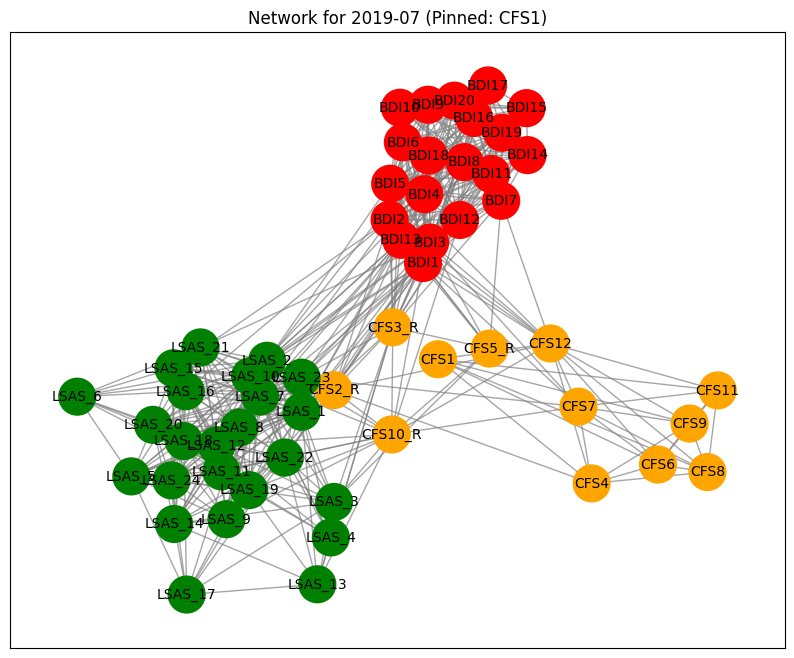

Analyzing network for 2020-01...
Number of nodes: 54
Number of edges: 404


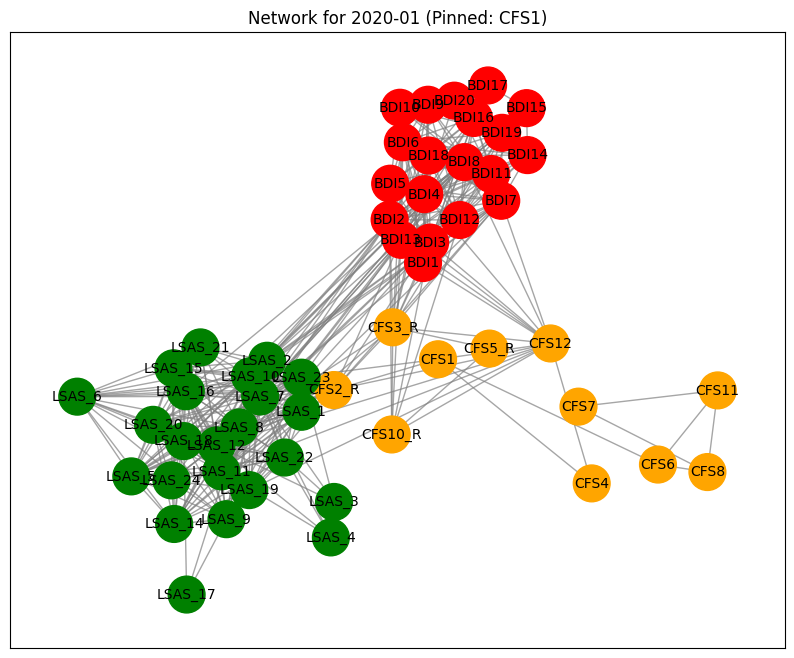

Analyzing network for 2020-05...
Number of nodes: 55
Number of edges: 289


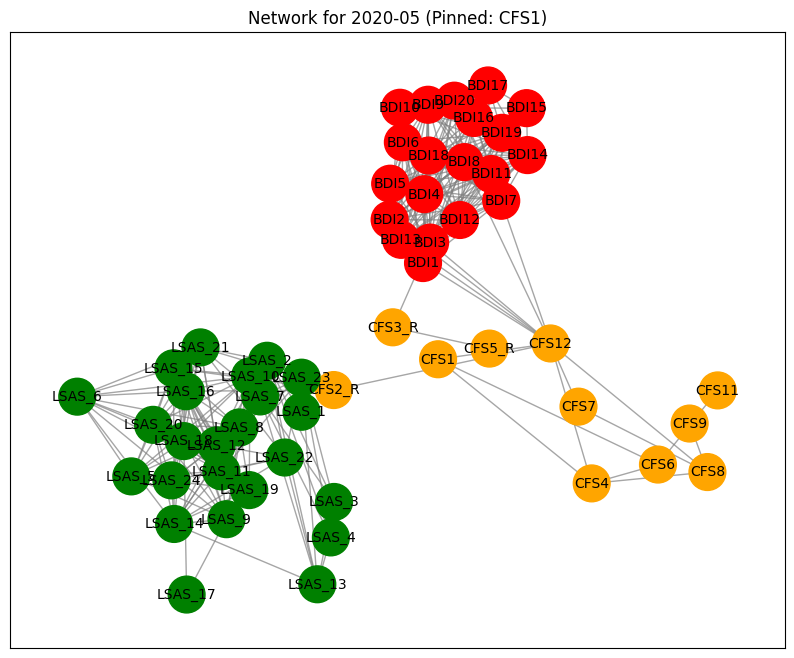

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define months for analysis
months = ['2019-07', '2020-01', '2020-05']

# Define color mapping for test types
color_mapping = {
    'BDI': 'red',
    'LSAS': 'green',
    'CFS': 'orange'
}

# Function to assign colors based on test type
def assign_color(node):
    for test, color in color_mapping.items():
        if test in node:  # Check if the test type is in the node name
            return color
    return 'gray'  # Default color for unmatched nodes

# Function to construct and analyze a network with a pinned node and consistent layout
def analyze_networks(dataframes, pin_node='CFS1', threshold=0.4):
    global_layout = None  # Store the global layout
    
    for month, data in dataframes.items():
        print(f"Analyzing network for {month}...")
        
        # Compute correlation matrix
        corr_matrix = data.corr()
        
        # Initialize a graph
        G = nx.Graph()
        full_to_short = {}  # Mapping from full to short names
        
        # Add edges based on the threshold
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                if np.abs(corr_matrix.iloc[i, j]) > threshold:
                    full_name_i = corr_matrix.columns[i]
                    full_name_j = corr_matrix.columns[j]
                    short_name_i = full_name_i.split('_', 1)[1]
                    short_name_j = full_name_j.split('_', 1)[1]
                    G.add_edge(short_name_i, short_name_j, weight=corr_matrix.iloc[i, j])
                    
                    # Update the mapping
                    full_to_short[full_name_i] = short_name_i
                    full_to_short[full_name_j] = short_name_j

        # Ensure the pinned node exists
        if pin_node not in G.nodes:
            print(f"Pinned node '{pin_node}' not found in the network for {month}. Skipping pinning.")
            continue

        # Compute the layout
        if global_layout is None:
            # For the first network, calculate the layout
            pos = nx.spring_layout(G, seed=42)
            pos[pin_node] = [0, 0]  # Fix the position of the pinned node
            pos = nx.spring_layout(G, pos=pos, fixed=[pin_node])  # Refine layout
            global_layout = pos  # Save the global layout
        else:
            # Reuse the global layout
            pos = global_layout

        # Assign colors to nodes
        node_colors = [assign_color(node) for node in G.nodes]
        
        # Print graph properties
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        
        # Visualize the graph
        plt.figure(figsize=(10, 8))
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700)
        nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.7)
        nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
        plt.title(f"Network for {month} (Pinned: {pin_node})")
        plt.show()

# Prepare data for each month
dataframes = {}
for month in months:
    month_columns = [col for col in df.columns if month in col]
    month_data = df[month_columns].dropna()  # Drop rows with missing data
    dataframes[month] = month_data

# Perform network analysis with consistent layout
analyze_networks(dataframes, pin_node='CFS1')


In [10]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
import matplotlib.pyplot as plt
import networkx as nx



# Define time points (T1, T2, T3)
T1_columns = [col for col in df.columns if col.startswith('2019-07')]
T2_columns = [col for col in df.columns if col.startswith('2020-01')]
T3_columns = [col for col in df.columns if col.startswith('2020-05')]

# Combine time point data
T1_data = df[T1_columns].dropna()
T2_data = df[T2_columns].dropna()
T3_data = df[T3_columns].dropna()

# Use T1 data to learn structure
hc = HillClimbSearch(T1_data)
model = hc.estimate(scoring_method=BicScore(T1_data))

# Step 2: Bootstrapping for edge strengths
def bootstrap_edge_strength(data, model, n_bootstraps=100):
    # Initialize edge counts for edges in the original model
    edges_count = {edge: 0 for edge in model.edges()}
    
    for _ in range(n_bootstraps):
        # Create a bootstrap sample
        sample = data.sample(frac=1, replace=True)
        
        # Estimate a model on the bootstrap sample
        hc_bootstrap = HillClimbSearch(sample).estimate(scoring_method=BicScore(sample))
        
        # Count edges in the bootstrap sample
        for edge in hc_bootstrap.edges():
            if edge not in edges_count:
                edges_count[edge] = 0  # Initialize missing edges
            edges_count[edge] += 1
    
    # Normalize counts to probabilities
    total_bootstraps = n_bootstraps
    return {edge: count / total_bootstraps for edge, count in edges_count.items()}


# Step 3: Visualize the DAG
def visualize_dag(model, edge_strengths, title="Bayesian Network (DAG)"):
    # Convert to a NetworkX graph
    G = nx.DiGraph()
    G.add_edges_from(model.edges())
    
    # Get edge weights for visualization
    weights = [edge_strengths[edge] if edge in edge_strengths else 0 for edge in G.edges()]
    
    # Plot the DAG
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=weights)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
    plt.title(title)
    plt.show()

# Compute edge strengths for T1
edge_strengths_T1 = bootstrap_edge_strength(T1_data, model)

# Visualize the learned Bayesian Network for T1
visualize_dag(model, edge_strengths_T1, title="Bayesian Network (T1 - 2019-07)")

# For T2 and T3, repeat the process with their respective data
hc_T2 = HillClimbSearch(T2_data).estimate(scoring_method=BicScore(T2_data))
edge_strengths_T2 = bootstrap_edge_strength(T2_data, hc_T2)
visualize_dag(hc_T2, edge_strengths_T2, title="Bayesian Network (T2 - 2020-01)")

hc_T3 = HillClimbSearch(T3_data).estimate(scoring_method=BicScore(T3_data))
edge_strengths_T3 = bootstrap_edge_strength(T3_data, hc_T3)
visualize_dag(hc_T3, edge_strengths_T3, title="Bayesian Network (T3 - 2020-05)")


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
import matplotlib.pyplot as plt
import networkx as nx

# Define time points (T1, T2, T3)
T1_columns = [col for col in df.columns if col.startswith('2019-07')]
T2_columns = [col for col in df.columns if col.startswith('2020-01')]
T3_columns = [col for col in df.columns if col.startswith('2020-05')]

# Combine time point data
T1_data = df[T1_columns].dropna()

# Use T1 data to learn structure
hc = HillClimbSearch(T1_data)
model = hc.estimate(scoring_method=BicScore(T1_data))
print("Learned model edges:", model.edges())

# Modified bootstrapping function
def bootstrap_edge_strength(data, model, n_bootstraps=100):
    edges_count = {edge: 0 for edge in model.edges()}
    print(f"Edges in the original model: {model.edges()}")

    for i in range(n_bootstraps):
        print(f"Bootstrap iteration {i + 1}/{n_bootstraps}...")
        sample = data.sample(frac=1, replace=True)
        
        try:
            hc_bootstrap = HillClimbSearch(sample).estimate(scoring_method=BicScore(sample))
            for edge in hc_bootstrap.edges():
                if edge not in edges_count:
                    edges_count[edge] = 0  # Initialize missing edges
                edges_count[edge] += 1
        except Exception as e:
            print(f"Error in bootstrap iteration {i + 1}: {e}")
    
    print("Completed bootstrapping.")
    return {edge: count / n_bootstraps for edge, count in edges_count.items()}

# Test single iteration
print("Starting single iteration test...")
sample = T1_data.sample(frac=1, replace=True)
hc_bootstrap = HillClimbSearch(sample).estimate(scoring_method=BicScore(sample))
print("Edges from single bootstrap sample:", hc_bootstrap.edges())

# Test bootstrapping with 5 iterations
print("Starting small test with 5 bootstraps...")
edge_strengths_test = bootstrap_edge_strength(T1_data, model, n_bootstraps=5)
print("Bootstrap test results:", edge_strengths_test)


  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned model edges: []
Starting single iteration test...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges from single bootstrap sample: [('2019-07_BDI1', '2019-07_BDI13'), ('2019-07_BDI1', '2019-07_BDI2'), ('2019-07_BDI1', '2019-07_BDI12'), ('2019-07_BDI1', '2019-07_BDI11'), ('2019-07_BDI8', '2019-07_BDI1')]
Starting small test with 5 bootstraps...
Edges in the original model: []
Bootstrap iteration 1/5...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Bootstrap iteration 2/5...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Bootstrap iteration 3/5...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Bootstrap iteration 4/5...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Bootstrap iteration 5/5...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Completed bootstrapping.
Bootstrap test results: {('2019-07_BDI11', '2019-07_BDI4'): 0.2, ('2019-07_BDI13', '2019-07_BDI3'): 0.2, ('2019-07_BDI2', '2019-07_BDI7'): 0.2, ('2019-07_BDI3', '2019-07_BDI2'): 0.2, ('2019-07_BDI3', '2019-07_BDI5'): 0.2, ('2019-07_BDI4', '2019-07_BDI1'): 0.4, ('2019-07_BDI4', '2019-07_BDI10'): 0.2, ('2019-07_BDI10', '2019-07_BDI1'): 0.4, ('2019-07_BDI10', '2019-07_BDI16'): 0.2, ('2019-07_BDI1', '2019-07_BDI13'): 0.6, ('2019-07_BDI1', '2019-07_BDI8'): 0.4, ('2019-07_BDI10', '2019-07_BDI14'): 0.4, ('2019-07_BDI14', '2019-07_BDI19'): 0.6, ('2019-07_BDI16', '2019-07_BDI10'): 0.2, ('2019-07_BDI1', '2019-07_BDI4'): 0.2, ('2019-07_BDI1', '2019-07_BDI3'): 0.4, ('2019-07_BDI1', '2019-07_BDI7'): 0.4, ('2019-07_BDI1', '2019-07_BDI2'): 0.4, ('2019-07_BDI1', '2019-07_BDI16'): 0.4, ('2019-07_BDI1', '2019-07_BDI10'): 0.4, ('2019-07_BDI1', '2019-07_BDI18'): 0.4, ('2019-07_BDI1', '2019-07_BDI11'): 0.4, ('2019-07_BDI8', '2019-07_BDI1'): 0.2, ('2019-07_BDI1', '2019-07_BDI14'): 0

In [14]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
import matplotlib.pyplot as plt
import networkx as nx


# Define time points (T1, T2, T3)
T1_columns = [col for col in df.columns if col.startswith('2019-07')]
T2_columns = [col for col in df.columns if col.startswith('2020-01')]
T3_columns = [col for col in df.columns if col.startswith('2020-05')]

# Combine time point data
T1_data = df[T1_columns].dropna()
T2_data = df[T2_columns].dropna()
T3_data = df[T3_columns].dropna()

# Use T1 data to learn structure
hc = HillClimbSearch(T1_data)
model = hc.estimate(scoring_method=BicScore(T1_data))

# Step 2: Bootstrapping for edge strengths
def bootstrap_edge_strength(data, model, n_bootstraps=100):
    # Initialize edge counts for edges in the original model
    edges_count = {edge: 0 for edge in model.edges()}
    
    for _ in range(n_bootstraps):
        # Create a bootstrap sample
        sample = data.sample(frac=1, replace=True)
        
        # Estimate a model on the bootstrap sample
        hc_bootstrap = HillClimbSearch(sample).estimate(scoring_method=BicScore(sample))
        
        # Count edges in the bootstrap sample
        for edge in hc_bootstrap.edges():
            if edge not in edges_count:
                edges_count[edge] = 0  # Initialize missing edges
            edges_count[edge] += 1
    
    # Normalize counts to probabilities
    total_bootstraps = n_bootstraps
    return {edge: count / total_bootstraps for edge, count in edges_count.items()}


# Step 3: Visualize the DAG
def visualize_dag(model, edge_strengths, title="Bayesian Network (DAG)"):
    # Convert to a NetworkX graph
    G = nx.DiGraph()
    G.add_edges_from(model.edges())
    
    # Get edge weights for visualization
    weights = [edge_strengths[edge] if edge in edge_strengths else 0 for edge in G.edges()]
    
    # Plot the DAG
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=weights)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
    plt.title(title)
    plt.show()

# Compute edge strengths for T1
edge_strengths_T1 = bootstrap_edge_strength(T1_data, model)

# Visualize the learned Bayesian Network for T1
visualize_dag(model, edge_strengths_T1, title="Bayesian Network (T1 - 2019-07)")

# For T2 and T3, repeat the process with their respective data
hc_T2 = HillClimbSearch(T2_data).estimate(scoring_method=BicScore(T2_data))
edge_strengths_T2 = bootstrap_edge_strength(T2_data, hc_T2)
visualize_dag(hc_T2, edge_strengths_T2, title="Bayesian Network (T2 - 2020-01)")

hc_T3 = HillClimbSearch(T3_data).estimate(scoring_method=BicScore(T3_data))
edge_strengths_T3 = bootstrap_edge_strength(T3_data, hc_T3)
visualize_dag(hc_T3, edge_strengths_T3, title="Bayesian Network (T3 - 2020-05)")


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
# Combine data from T1, T2, and T3
combined_data = pd.concat([T1_data, T2_data, T3_data], axis=0)
print("Combined shape before cleaning:", combined_data.shape)

# Check for missing values
print("Missing values per column:")
print(combined_data.isna().sum())

# Handle missing values (e.g., fill with column means)
combined_data = combined_data.fillna(combined_data.mean())
print("Shape after filling missing values:", combined_data.shape)

# Remove low-variance columns
combined_data = combined_data.loc[:, combined_data.nunique() > 1]
print("Shape after removing low-variance columns:", combined_data.shape)

# Ensure the dataset is valid
if combined_data.shape[0] == 0 or combined_data.shape[1] == 0:
    raise ValueError("Combined data is empty or has no valid columns after cleaning!")

# Learn the structure on the combined dataset
hc_combined = HillClimbSearch(combined_data)
model_combined = hc_combined.estimate(scoring_method=BicScore(combined_data))
print("Learned model edges for combined data:", model_combined.edges())

# Perform bootstrapping on the combined dataset
print("Starting combined bootstrapping...")
edge_strengths_combined = bootstrap_edge_strength(combined_data, model_combined, n_bootstraps=100)

# Visualize the combined DAG
visualize_dag(model_combined, edge_strengths_combined, title="Bayesian Network (Combined Data - Full Bootstrap)")


# Perform bootstrapping on the combined dataset
print("Starting combined bootstrapping...")
edge_strengths_combined = bootstrap_edge_strength(combined_data, model_combined, n_bootstraps=100)

# Visualize the combined DAG
visualize_dag(model_combined, edge_strengths_combined, title="Bayesian Network (Combined Data - Full Bootstrap)")




Combined shape before cleaning: (1264, 168)
Missing values per column:
2019-07_BDI1      920
2019-07_BDI10     920
2019-07_BDI11     920
2019-07_BDI12     920
2019-07_BDI13     920
                 ... 
2020-05_LSAS_5    689
2020-05_LSAS_6    689
2020-05_LSAS_7    689
2020-05_LSAS_8    689
2020-05_LSAS_9    689
Length: 168, dtype: int64
Shape after filling missing values: (1264, 168)
Shape after removing low-variance columns: (1264, 168)


  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned model edges for combined data: [('2019-07_BDI1', '2019-07_BDI4'), ('2019-07_BDI1', '2019-07_BDI13'), ('2019-07_BDI1', '2019-07_BDI8'), ('2019-07_BDI1', '2019-07_BDI3'), ('2019-07_BDI1', '2019-07_BDI2'), ('2019-07_BDI1', '2019-07_BDI5'), ('2019-07_BDI1', '2019-07_BDI7'), ('2019-07_BDI10', '2019-07_BDI1'), ('2019-07_BDI10', '2019-07_BDI16'), ('2019-07_BDI10', '2019-07_BDI18'), ('2019-07_BDI10', '2019-07_BDI14'), ('2019-07_BDI10', '2019-07_BDI12'), ('2019-07_BDI10', '2019-07_BDI17'), ('2019-07_BDI10', '2019-07_BDI9'), ('2019-07_BDI10', '2019-07_BDI11'), ('2019-07_BDI10', '2019-07_BDI15'), ('2019-07_BDI10', '2019-07_BDI6'), ('2019-07_BDI10', '2019-07_BDI20'), ('2019-07_BDI10', '2019-07_CFS11'), ('2019-07_BDI10', '2019-07_CFS7'), ('2019-07_BDI10', '2019-07_CFS9'), ('2019-07_BDI10', '2019-07_CFS1'), ('2019-07_BDI10', '2019-07_LSAS_3'), ('2019-07_BDI10', '2019-07_CFS6'), ('2019-07_BDI10', '2019-07_CFS8'), ('2019-07_BDI10', '2019-07_CFS10_R'), ('2019-07_BDI10', '2019-07_LSAS_4'), ('201

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
print("Combined data shape:", combined_data.shape)
print(combined_data.head())


Combined data shape: (0, 168)
Empty DataFrame
Columns: [2019-07_BDI1, 2019-07_BDI10, 2019-07_BDI11, 2019-07_BDI12, 2019-07_BDI13, 2019-07_BDI14, 2019-07_BDI15, 2019-07_BDI16, 2019-07_BDI17, 2019-07_BDI18, 2019-07_BDI19, 2019-07_BDI2, 2019-07_BDI20, 2019-07_BDI3, 2019-07_BDI4, 2019-07_BDI5, 2019-07_BDI6, 2019-07_BDI7, 2019-07_BDI8, 2019-07_BDI9, 2019-07_CFS1, 2019-07_CFS10_R, 2019-07_CFS11, 2019-07_CFS12, 2019-07_CFS2_R, 2019-07_CFS3_R, 2019-07_CFS4, 2019-07_CFS5_R, 2019-07_CFS6, 2019-07_CFS7, 2019-07_CFS8, 2019-07_CFS9, 2019-07_LSAS_1, 2019-07_LSAS_10, 2019-07_LSAS_11, 2019-07_LSAS_12, 2019-07_LSAS_13, 2019-07_LSAS_14, 2019-07_LSAS_15, 2019-07_LSAS_16, 2019-07_LSAS_17, 2019-07_LSAS_18, 2019-07_LSAS_19, 2019-07_LSAS_2, 2019-07_LSAS_20, 2019-07_LSAS_21, 2019-07_LSAS_22, 2019-07_LSAS_23, 2019-07_LSAS_24, 2019-07_LSAS_3, 2019-07_LSAS_4, 2019-07_LSAS_5, 2019-07_LSAS_6, 2019-07_LSAS_7, 2019-07_LSAS_8, 2019-07_LSAS_9, 2020-01_BDI1, 2020-01_BDI10, 2020-01_BDI11, 2020-01_BDI12, 2020-01_BDI13, 2

In [ ]:
combined_data


In [ ]:
combined_data